In [2]:
import cv2
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt

In [49]:
class AdaptiveThresholdBinarization:
    def __init__(self, block_size=15, C=2):
        self.block_size = block_size
        self.C = C

    def _validate_method(self, method):
        if method not in ['mean', 'gaussian']:
            raise ValueError("Method must be 'mean' or 'gaussian'")
    
    def adaptive_threshold_opencv(self, image, method='mean'):
        """Реализация с использованием OpenCV"""
        self._validate_method(method)

        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        if method == 'mean':
            adaptive_method = cv2.ADAPTIVE_THRESH_MEAN_C
        else:
            adaptive_method = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    
        return cv2.adaptiveThreshold(gray, 255, adaptive_method, cv2.THRESH_BINARY, self.block_size, self.C)

    def adaptive_threshold_native(self, image, method='mean'):
        self._validate_method(method)
    
        """Нативная реализация метода mean"""
        if len(image.shape) == 3:
            gray = np.round(np.mean(image, axis=-1)).astype(np.uint8)
        else:
            gray = image

        height, width = gray.shape
        result = np.zeros_like(gray, dtype=np.uint8)
        half_size = self.block_size // 2

        if method == 'mean':
            kernel = np.full((self.block_size, self.block_size), 1/(self.block_size**2))
        else:
            kernel = self._create_gaussian_kernel(self.block_size)
        
        for i in range(height):
            for j in range(width):
                # Определяем границы окрестности
                i_min = max(0, i - half_size)
                i_max = min(height, i + half_size + 1)
                j_min = max(0, j - half_size)
                j_max = min(width, j + half_size + 1)
                # Определяем границы ядра
                k_i_min = half_size - (i - i_min)
                k_i_max = half_size + (i_max - i)
                k_j_min = half_size - (j - j_min)
                k_j_max = half_size + (j_max - j)

                # Выбираем часть ядра и нормализуем
                kernel_part = kernel[k_i_min:k_i_max, k_j_min:k_j_max]
                kernel_part = kernel_part / np.sum(kernel_part)
                
                # Вычисляем взвешенное среднее
                neighborhood = gray[i_min:i_max, j_min:j_max]
                weighted_value = np.sum(neighborhood * kernel_part)
    
                # Применяем порог
                result[i, j] = 255 if gray[i, j] > weighted_value - self.C else 0
        
        return result

    def _create_gaussian_kernel(self, size, sigma=None):
        """Создает гауссово ядро"""
        if sigma is None:
            sigma = size / 6
        
        center = size // 2
        
        rng = np.arange(-center, size-center)
        x, y = np.meshgrid(rng, rng)
        kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))

        return kernel

In [38]:
def compare_performance(image, block_size=15, C=2, with_img_results: bool = True):
    """Сравнение производительности разных реализаций"""
    # Загружаем изображение
    binarizer = AdaptiveThresholdBinarization(block_size, C)
    
    results = {}
    methods = ['mean', 'gaussian']
    
    for method in methods:
        # OpenCV реализация
        start_time = time.time()
        result_cv = binarizer.adaptive_threshold_opencv(image, method)
        cv_time = time.time() - start_time
        
        # Нативная реализация
        start_time = time.time()
        result_native = binarizer.adaptive_threshold_native(image, method)
        native_time = time.time() - start_time

        # Вычисляем разницу между результатами
        difference = np.sum(np.abs(result_cv.astype(int) - result_native.astype(int))) / (255 * result_cv.size)
        
        results[method] = {
            'opencv_time': cv_time,
            'native_time': native_time,
            'opencv_pixel_time': cv_time / (image.shape[0] * image.shape[1]) * 10**9,
            'native_pixel_time': native_time / (image.shape[0] * image.shape[1]) * 10**9,
            'difference_percentage': difference * 100
        }
        if with_img_results:
            results[method]['opencv_result'] = result_cv
            results[method]['native_result'] = result_native
    
    return results

In [33]:
def plot_results(original, results):
    """Визуализация результатов"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    methods = ['mean', 'gaussian']
    for idx, method in enumerate(methods):
        # Оригинальное изображение
        axes[idx, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[idx, 0].set_title('Оригинальное изображение')
        axes[idx, 0].axis('off')
        # OpenCV результат
        axes[idx, 1].imshow(results[method]['opencv_result'], cmap='gray')
        axes[idx, 1].set_title(f'OpenCV {method}\nВремя: {results[method]["opencv_time"]:.3f}с')
        axes[idx, 1].axis('off')
        
        # Нативный результат
        axes[idx, 2].imshow(results[method]['native_result'], cmap='gray')
        axes[idx, 2].set_title(f'Нативная {method}\nВремя: {results[method]["native_time"]:.3f}с\nРазница: {results[method]["difference_percentage"]:.2f}%')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('results_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

In [34]:
def performance_analysis(image, block_sizes=[5, 11, 15, 21, 31], C=2):
    """Анализ производительности для разных размеров блоков"""
    methods = ['mean', 'gaussian']
    algorithms = ["cv", "native"]
    times = {f"{alg}_{met}": [] for alg in algorithms for met in methods}
    
    for block_size in block_sizes:
        binarizer = AdaptiveThresholdBinarization(block_size, C)

        for method in methods:
            for algorithm in algorithms:
                start_time = time.time()
                if algorithm == "cv":
                    binarizer.adaptive_threshold_opencv(image, method)
                else:
                    binarizer.adaptive_threshold_native(image, method)
                end_time = time.time()
                times[f"{algorithm}_{method}"].append(end_time - start_time)
    
    # График производительности
    plt.figure(figsize=(12, 8))
    
    for idx, method in enumerate(methods, 1):
        plt.subplot(2, 1, idx)
        plt.plot(block_sizes, times[f"cv_{method}"], 'o-', label=f'OpenCV {method}')
        plt.plot(block_sizes, times[f"native_{method}"], 's-', label=f'Нативная {method}')
        plt.xlabel('Размер блока')
        plt.ylabel('Время (секунды)')
        plt.title(f'Сравнение производительности: {method} метод')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('performance_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return {
        'block_sizes': block_sizes,
        'times': times
    }

In [51]:
def syntetic_tests(
        n_tests: int = 100, img_size_min: int = 300, img_size_max: int = 1000,
        block_size=15, C=2
):
    methods = ['mean', 'gaussian']
    total_results = {met: {} for met in methods}

    for i in range(n_tests):
        random_shape = np.random.randint(img_size_min, img_size_max, 2)
        test_image = np.random.randint(0, 255, (random_shape[0], random_shape[1], 3), dtype=np.uint8)

        test_res = compare_performance(test_image, block_size=block_size, C=C, with_img_results=False)
        for method in methods:
            prev_res = total_results[method]
            total_results[method] = {
                'opencv_pixel_time': test_res[method]['opencv_pixel_time'] + prev_res.get('opencv_pixel_time', 0),
                'native_pixel_time': test_res[method]['native_pixel_time'] + prev_res.get('native_pixel_time', 0),
                'difference_percentage': test_res[method]['difference_percentage'] + prev_res.get('difference_percentage', 0)
            }
        print(f"\r {i + 1} / {n_tests}", end="")

    print(f"\rBenchmark results ({n_tests} tests):")
    print(f"=== РЕЗУЛЬТАТЫ БЕНЧМАРКА ({n_tests} тестов) ===")

    for method in methods:
        print(f"\n{method.upper()} МЕТОД:")
        for key in total_results[method].keys():
            total_results[method][key] /= n_tests
            print(f" - Avg. {key} = {total_results[method][key]:.3f} {'ns' if key.endswith('_time') else '%'}")

    return total_results

In [52]:
_ = syntetic_tests(n_tests=10)

Benchmark results (10 tests):
=== РЕЗУЛЬТАТЫ БЕНЧМАРКА (10 тестов) ===

MEAN МЕТОД:
 - Avg. opencv_pixel_time = 4.138 ns
 - Avg. native_pixel_time = 4157.170 ns
 - Avg. difference_percentage = 18.459 %

GAUSSIAN МЕТОД:
 - Avg. opencv_pixel_time = 1.982 ns
 - Avg. native_pixel_time = 4132.255 ns
 - Avg. difference_percentage = 18.438 %


Запуск сравнения производительности...

=== РЕЗУЛЬТАТЫ СРАВНЕНИЯ ===

MEAN МЕТОД:
  OpenCV время: 0.0012 сек
  Нативное время: 1.1049 сек
  Ускорение OpenCV: 932.09x
  Разница результатов: 3.0804%

GAUSSIAN МЕТОД:
  OpenCV время: 0.0005 сек
  Нативное время: 1.0869 сек
  Ускорение OpenCV: 2148.40x
  Разница результатов: 3.6736%


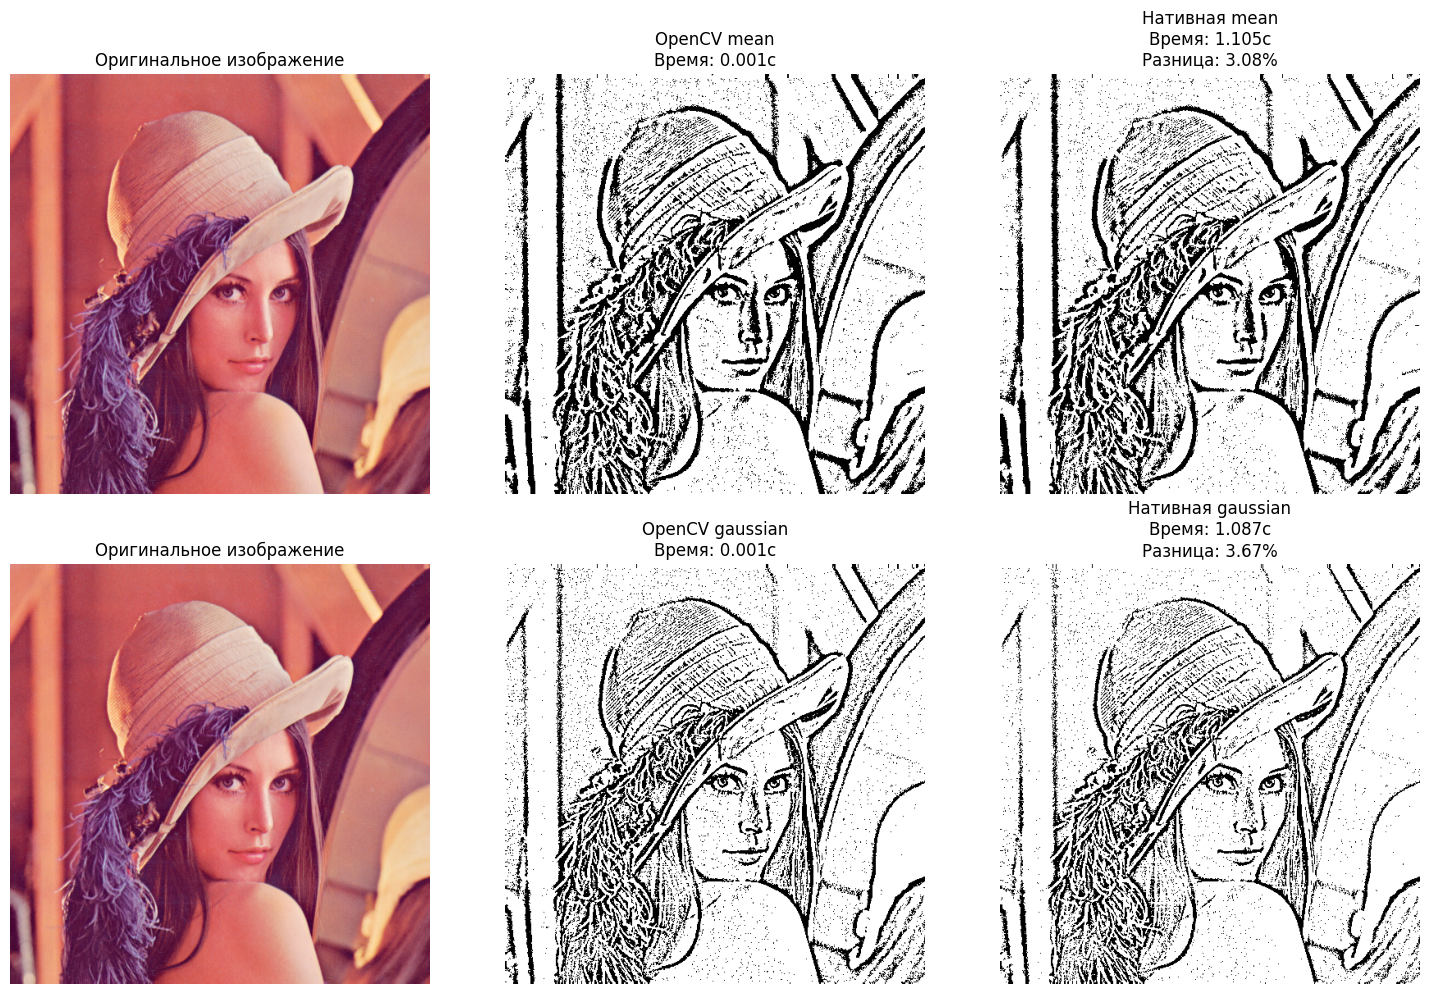


Запуск анализа производительности...


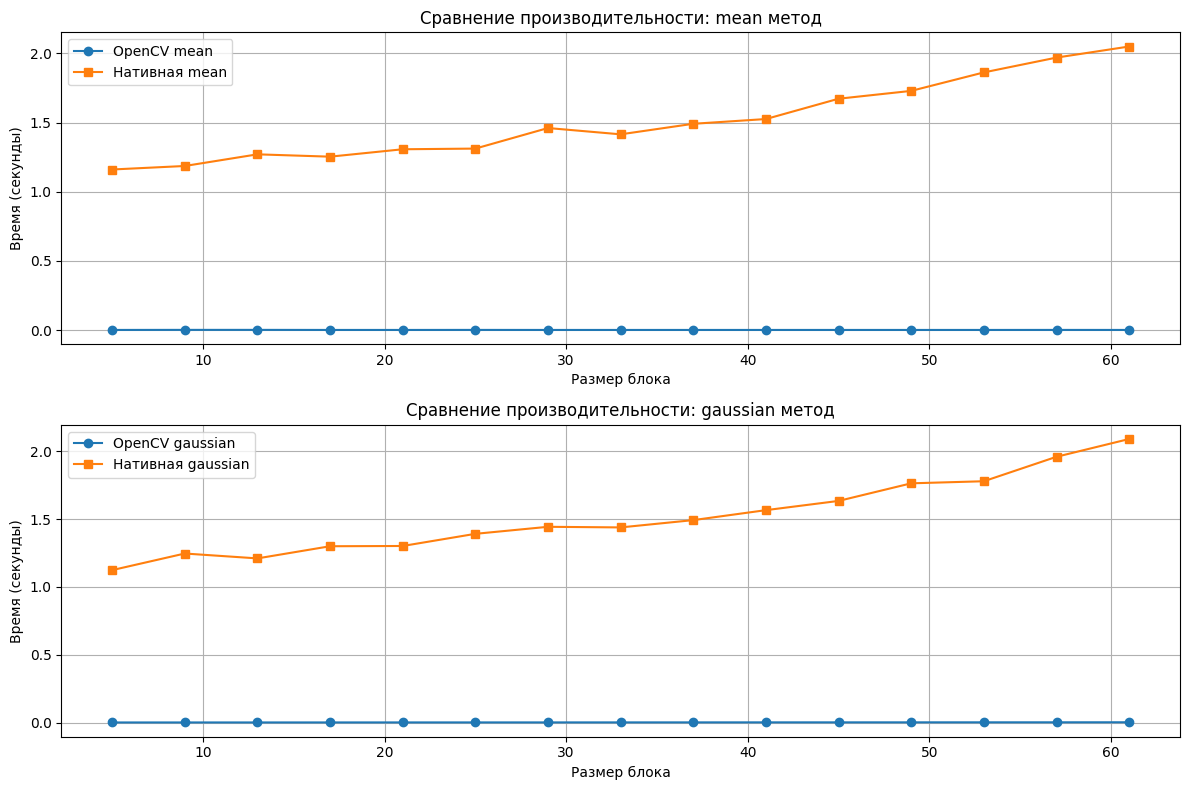

In [ ]:
image_path = "./images/girl_with_hat.png"

image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Не удалось загрузить изображение: {image_path}")

# Сравнение методов
print("Запуск сравнения производительности...")
results = compare_performance(image, block_size=15, C=5)

# Вывод результатов
print("\n=== РЕЗУЛЬТАТЫ СРАВНЕНИЯ ===")
for method in ['mean', 'gaussian']:
    data = results[method]
    print(f"\n{method.upper()} МЕТОД:")
    print(f"  OpenCV время: {data['opencv_time']:.4f} сек")
    print(f"  Нативное время: {data['native_time']:.4f} сек")
    print(f"  Ускорение OpenCV: {data['native_time']/data['opencv_time']:.2f}x")
    print(f"  Разница результатов: {data['difference_percentage']:.4f}%")

# Визуализация
plot_results(image, results)

# Анализ производительности
print("\nЗапуск анализа производительности...")
block_sizes = np.arange(5, 65, 4)
perf_data = performance_analysis(image, block_sizes=block_sizes)